In [1]:
from utils import load_dtrajs_from_npz
raw_dtrajs_abl = load_dtrajs_from_npz('dtrajs/abl_11400_2000_dtrajs.npz')

# trim dtrajs when building MSM
def trim_dtrajs(dtrajs,length_to_discard=10,min_length=100):
    trimmed = [traj[length_to_discard:] for traj in dtrajs if len(traj)>length_to_discard]
    return trimmed

dtrajs_abl = trim_dtrajs(raw_dtrajs_abl)

# build MSM
import msmbuilder.msm
lag_frames = 40
ergodic_cutoff_in_frames=20
ergodic_cutoff = 1.0*ergodic_cutoff_in_frames/lag_frames
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())
M = mb_msm_abl

MSM contains 1430 strongly connected components above weight=0.50. Component 178 selected, with population 72.095405%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 338
Number of nonzero entries in counts matrix : 6216 (5.44098595988%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.1
    Mean   : 2.2
    3rd Qu.: 0.5
    Max.   : 1487.5

Total transition counts :
    13631.35 counts
Total transition counts / lag_time:
    340.78375 units
Timescales:
    [2169.54, 1907.65, 1858.34, 1800.73, 1659.07, 1590.01, 1542.29, 1477.60, 1345.10, 1332.19, 1191.67, 1156.80, 1068.17, 982.33, 933.27, 815.23, 752.10, 700.40, 695.71, 647.44, 637.63, 629.52, 600.83, 540.80, 534.18, 532.25, 529.38, 506.88, 501.71, 420.72, 402.92, 399.72, 398.36, 386.80, 382.91, 381.67, 379.46, 372.06, 366.12, 364.78, 362.00, 356.31, 339.54, 328.00, 324.58, 324.00, 315.33, 300.18, 295.68, 285

In [182]:
import numpy as np

def flat_probs_from_msm(flat_labels,M,n_micro=2000):

    # probability per snapshot = microstate_probability/nsamples_in_microstate
    label_probabilities = np.zeros(n_micro)
    for label in M.mapping_:
        nsamples_per_label = np.sum(flat_labels==label)
        pi_label = M.populations_[M.mapping_[label]]
        label_probabilities[label] = pi_label / nsamples_per_label
    flat_probs = np.array([label_probabilities[i] for i in flat_labels])
    
    return flat_probs

# flatten labels
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,M,n_micro=len(set(flat_labels)))

# define reducing function to color each bin: 
# free energy of a bin = -\ln (\sum_snapshots probability(snapshot))
reducing_function = lambda x:-np.log(np.sum(x))

# get locations
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

In [183]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
%matplotlib inline

In [184]:
_np = np
_plt = plt
# stolen and modified from: https://github.com/markovmodel/PyEMMA/blob/devel/pyemma/plots/plots2d.py#L96-L149
def mod_plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, offset=0.1,
                     cmap='spectral', cbar=True, cbar_label='Free energy (kT)'):
    """Free energy plot given 2D scattered data
    Builds a 2D-histogram of the given data points and plots -log(p) where p is
    the probability computed from the histogram count.
    Parameters
    ----------
    xall : ndarray(T)
        sample x-coordinates
    yall : ndarray(T)
        sample y-coordinates
    weights : ndarray(T), default = None
        sample weights. By default all samples have the same weight
    ax : matplotlib Axes object, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    nbins : int, default=100
        number of histogram bins used in each dimension
    offset : float, default=0.1
        small additive shift to the histogram. This creates a small bias to the
        distribution, but gives a better visual impression with the default
        colormap.
    cmap : matplotlib colormap, optional, default = None
        the color map to use. None will use pylab.cm.spectral.
    cbar : boolean, default=True
        plot a color bar
    cbar_label : str or None, default='Free energy (kT)'
        colorbar label string. Use None to suppress it.
    Returns
    -------
    ax : Axes object containing the plot
    fig : Figure object containing the plot
    """
    import matplotlib.pylab as _plt

    z, x, y = _np.histogram2d(xall, yall, bins=nbins, weights=weights)
    z += offset
    # compute free energies
    F = -_np.log(z)
    
    # subtract minimum!
    F -= F.min()
    
    
    # do a contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    if ax is None:
        ax = _plt.gca()
    CS = ax.contourf(F.T, 100, extent=extent, cmap=cmap,
                     #hatches=True,
                    )
    #ax.contour(F.T)
    
    if cbar:
        cbar = _plt.colorbar(CS)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax, _plt.gcf()

In [185]:
help(plt.hexbin)

Help on function hexbin in module matplotlib.pyplot:

hexbin(x, y, C=None, gridsize=100, bins=None, xscale=u'linear', yscale=u'linear', extent=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=u'none', reduce_C_function=<function mean>, mincnt=None, marginals=False, hold=None, data=None, **kwargs)
    Make a hexagonal binning plot.
    
    Call signature::
    
       hexbin(x, y, C = None, gridsize = 100, bins = None,
              xscale = 'linear', yscale = 'linear',
              cmap=None, norm=None, vmin=None, vmax=None,
              alpha=None, linewidths=None, edgecolors='none'
              reduce_C_function = np.mean, mincnt=None, marginals=True
              **kwargs)
    
    Make a hexagonal binning plot of *x* versus *y*, where *x*,
    *y* are 1-D sequences of the same length, *N*. If *C* is *None*
    (the default), this is a histogram of the number of occurences
    of the observations at (x[i],y[i]).
    
    If *C* is specifi

In [186]:
# define reducing function to color each bin: 
# free energy of a bin = -\ln (\sum_snapshots probability(snapshot))
reducing_function = lambda x:-np.log(np.sum(x)+0.00001)-5.8
# note I added a small offset to prevent the log from blowing up

# maybe I can get away with using an if clause instead
#def reducing_function_(x):
#    s = np.sum(x)
#    if s==0:
#        return 0
#    else:
#        return -np.log(s)
    
# nope that looks awful as well, reverting to a small offset

In [198]:
# hacky but I'm not sure how else to subtract the minimum value from the hex-bin plots
minimum_last_run=np.inf
def reducing_function(x,offset=0.00001):
    raw = -np.log(np.sum(x)+offset)
    global minimum_last_run
    minimum_last_run = min(raw,minimum_last_run)
    return raw - minimum_last_run

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


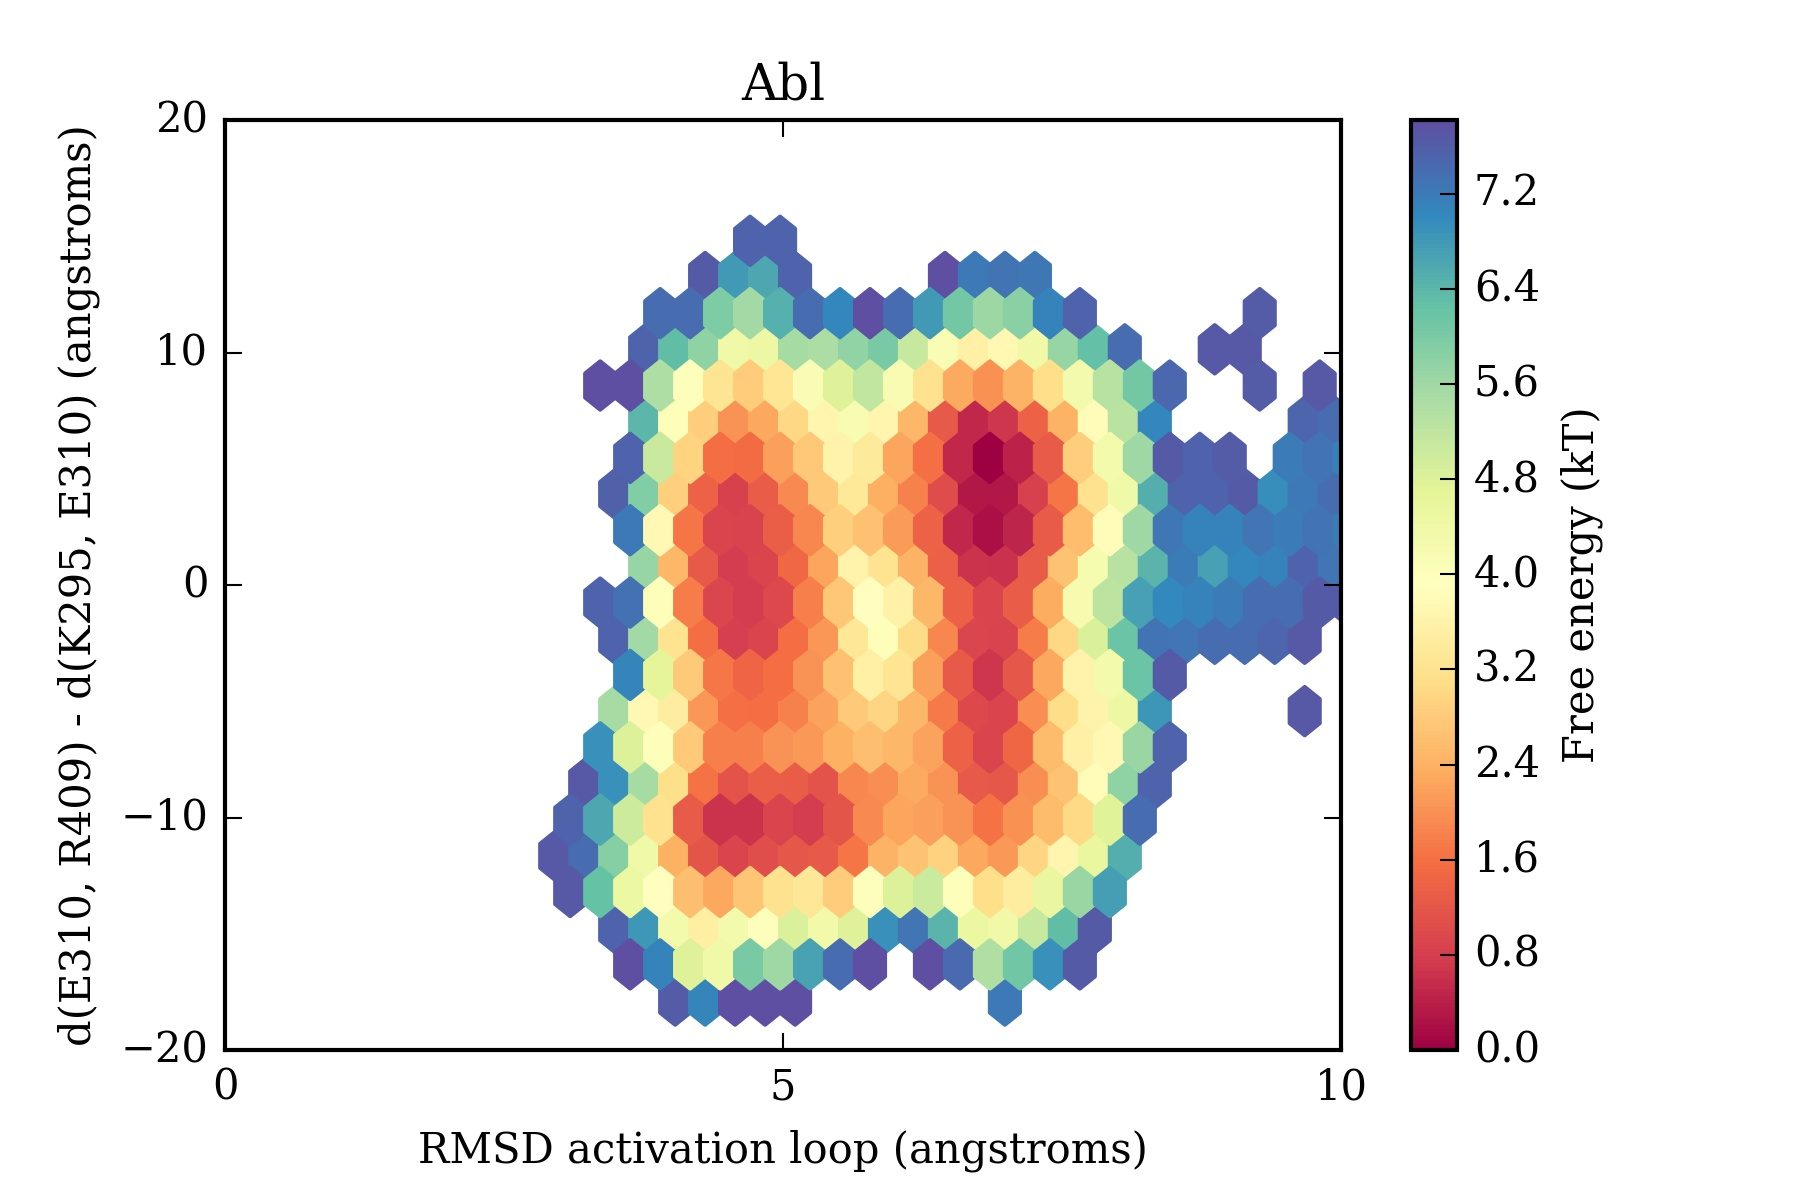

In [204]:
import pyemma
from IPython.display import Image


def shukla_plot_pe(X1,X2,flat_probs,title='Abl',bins=100):

    ax = plt.gca()
    ax.set_xlim(0,10)
    ax.set_ylim(-20,20)
    ax.set_xticks([0,5,10])
    ax.set_yticks([-20,-10,0,10,20])

    mod_plot_free_energy(X1,X2,flat_probs,ax,offset=0,nbins=bins,
                         #cmap='BuGn_r',
                         #cmap='Spectral_r',
                         #cmap='spectral_r',
                         cmap='Spectral'
                        )

    plt.xlabel('RMSD activation loop (angstroms)')
    plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
    plt.title(title)
    plt.savefig('{0}_free_energy_landscape_pe.jpg'.format(title),dpi=300)
    
    
    return ax

  
def shukla_plot_hex(X1,X2,flat_probs,title='Abl',bins=100):
    global minimum_last_run
    minimum_last_run=np.inf
    for i in range(2):
        plt.close()
        cbar_label='Free energy (kT)'
        ax = plt.gca()
        ax.set_xlim(0,10)
        ax.set_ylim(-20,20)
        ax.set_xticks([0,5,10])
        ax.set_yticks([-20,-10,0,10,20])

        cs = plt.hexbin(X1,X2,C=flat_probs,
                   gridsize=bins,
                   cmap='Spectral',
                   reduce_C_function=reducing_function,
                   #reduce_C_function=np.sum

                  )
        plt.xlabel('RMSD activation loop (angstroms)')
        plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
        plt.title(title)
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel(cbar_label)


        # plt.colorbar()
    
    
    plt.savefig('{0}_free_energy_landscape_hex.jpg'.format(title),dpi=300)
    
bins=36
shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()

Image('Abl_free_energy_landscape_hex.jpg',retina=True)

In [205]:
minimum_last_run

3.6925275415180674

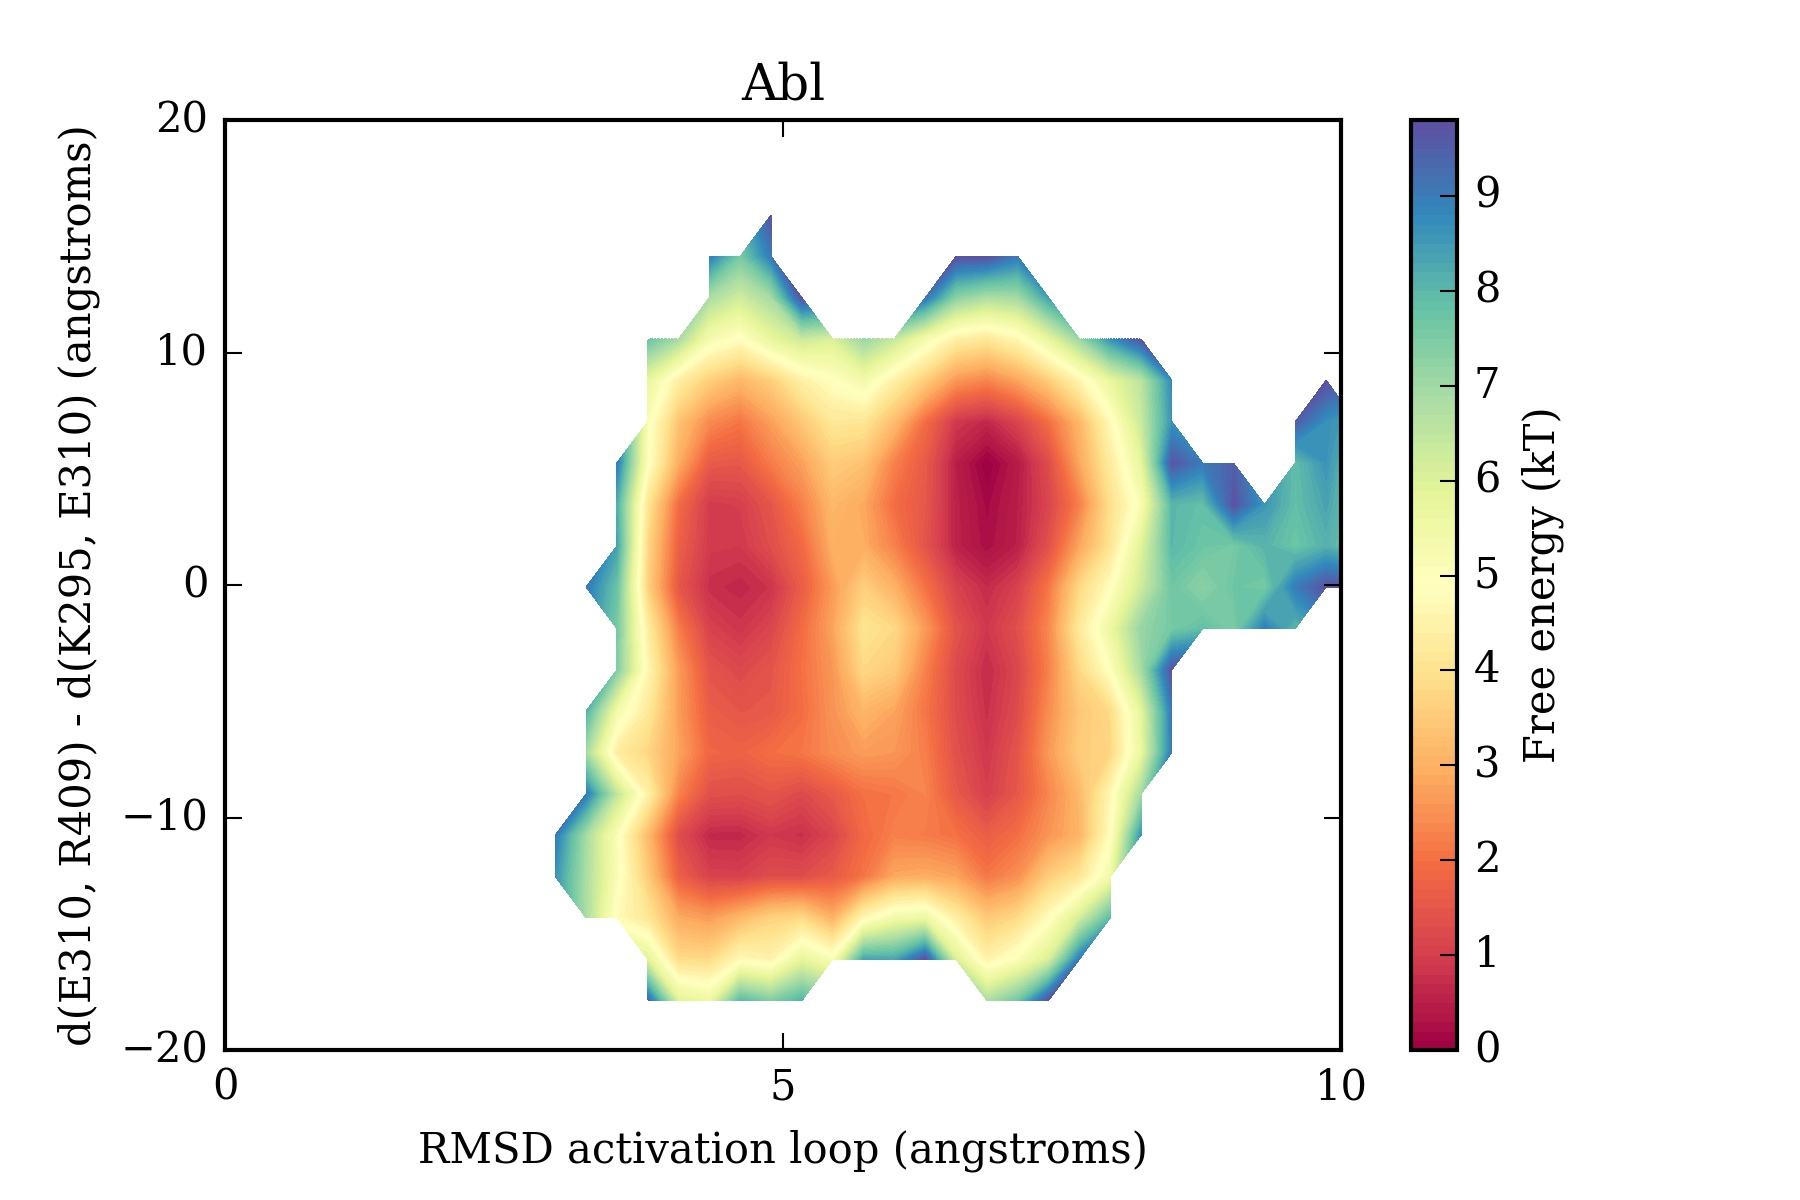

In [206]:
Image('Abl_free_energy_landscape_pe.jpg',retina=True)

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


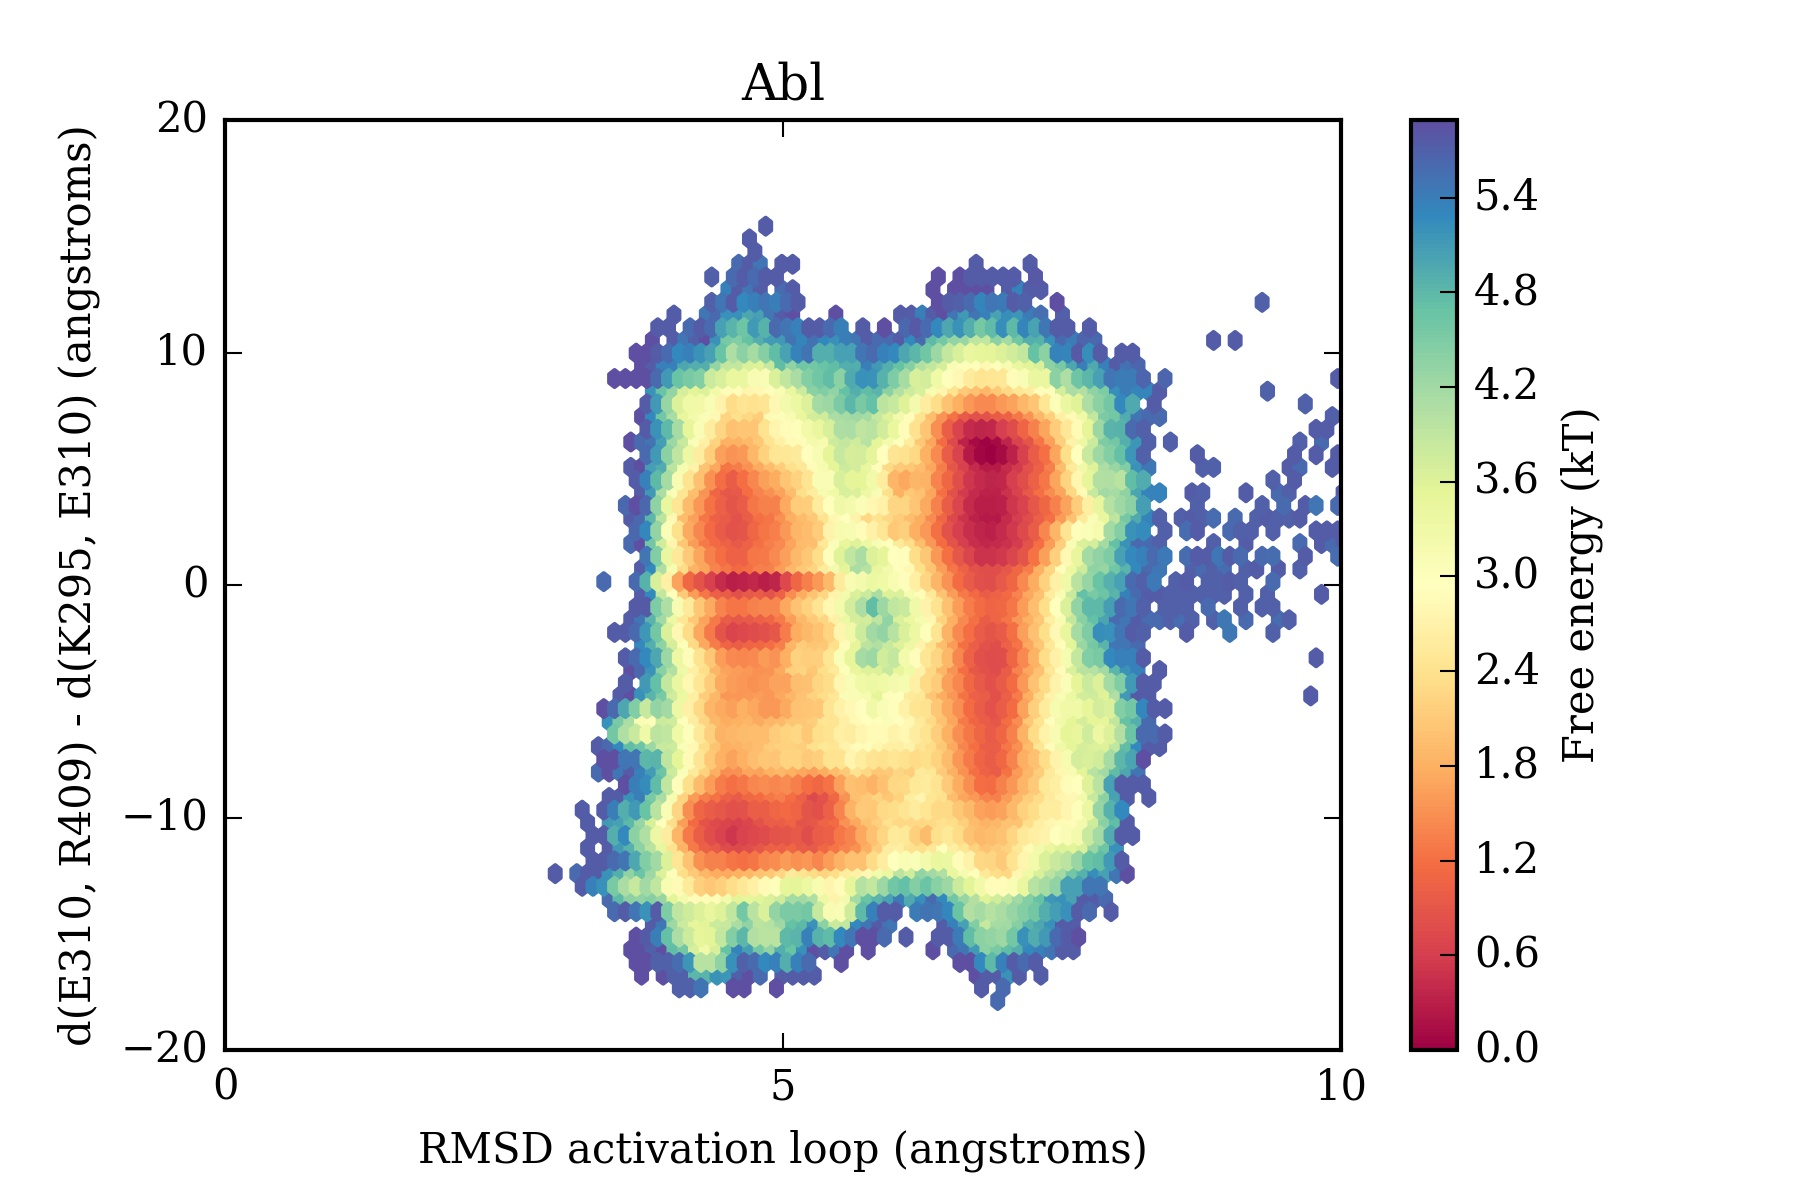

In [207]:
bins=100

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Abl',bins=bins)
plt.close()

Image('Abl_free_energy_landscape_hex.jpg',retina=True)

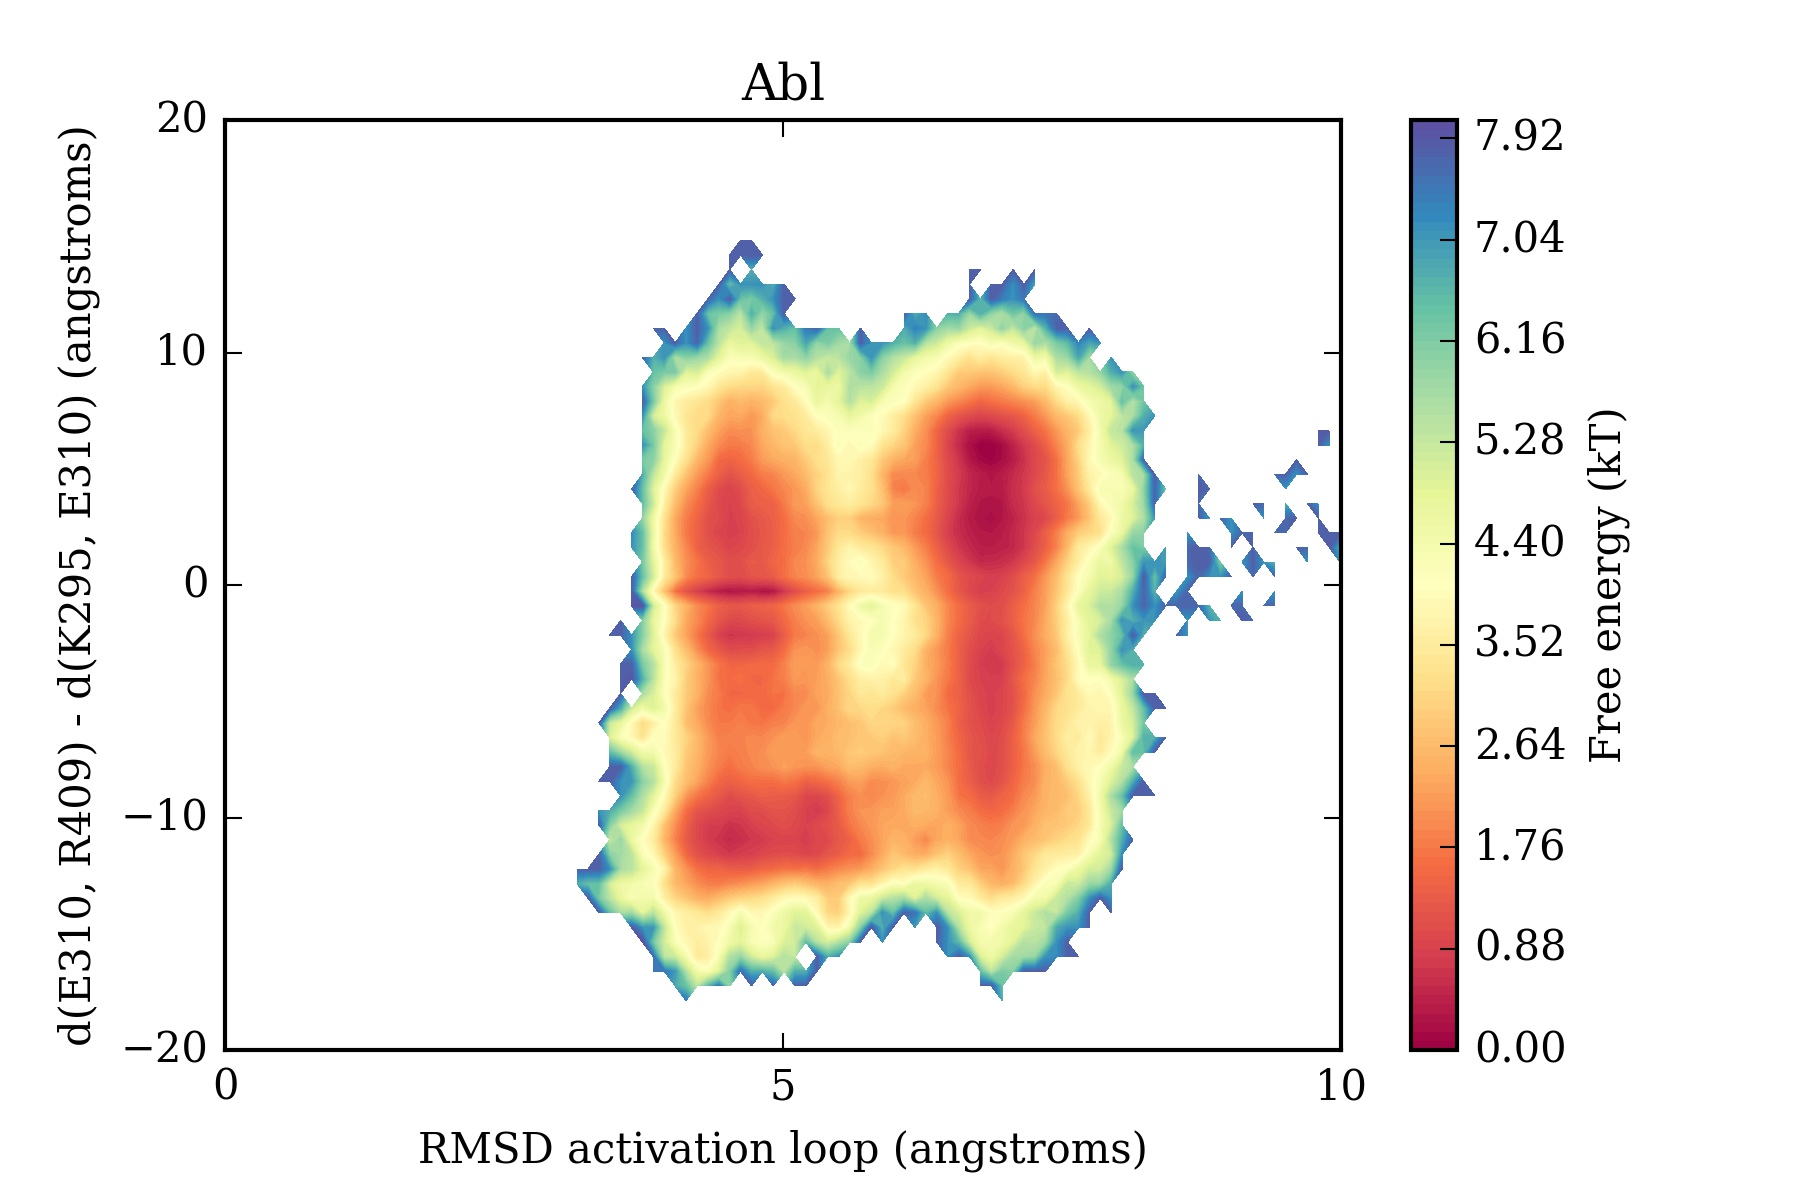

In [208]:
Image('Abl_free_energy_landscape_pe.jpg',retina=True)

In [209]:
# # without weights
# shukla_plot(X1,X2,np.ones(len(X1)),'Abl_flat')
# Image('Abl_flat_free_energy_landscape.jpg',retina=True)

MSM contains 1789 strongly connected components above weight=0.50. Component 49 selected, with population 23.611457%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 52
Number of nonzero entries in counts matrix : 1153 (42.6405325444%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 0.9
    3rd Qu.: 0.7
    Max.   : 61.7

Total transition counts :
    991.9 counts
Total transition counts / lag_time:
    24.7975 units
Timescales:
    [2308.10, 1141.29, 346.74, 293.34, 258.27, 200.46, 168.38, 152.31, 97.69, 92.18, 55.69, 52.05, 47.25, 40.30, 36.65, 36.12, 34.67, 34.10, 33.49, 32.46, 31.89, 30.82, 29.98, 29.23, 28.68, 27.99, 27.18, 26.23, 25.63, 24.72, 24.21, 23.79, 23.23, 22.49, 22.08, 21.65, 21.46, 21.01, 20.38, 19.89, 19.03, 18.70, 16.98, 15.40, 15.14, 14.36, 12.20, nan, nan, nan, nan]  units



/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log


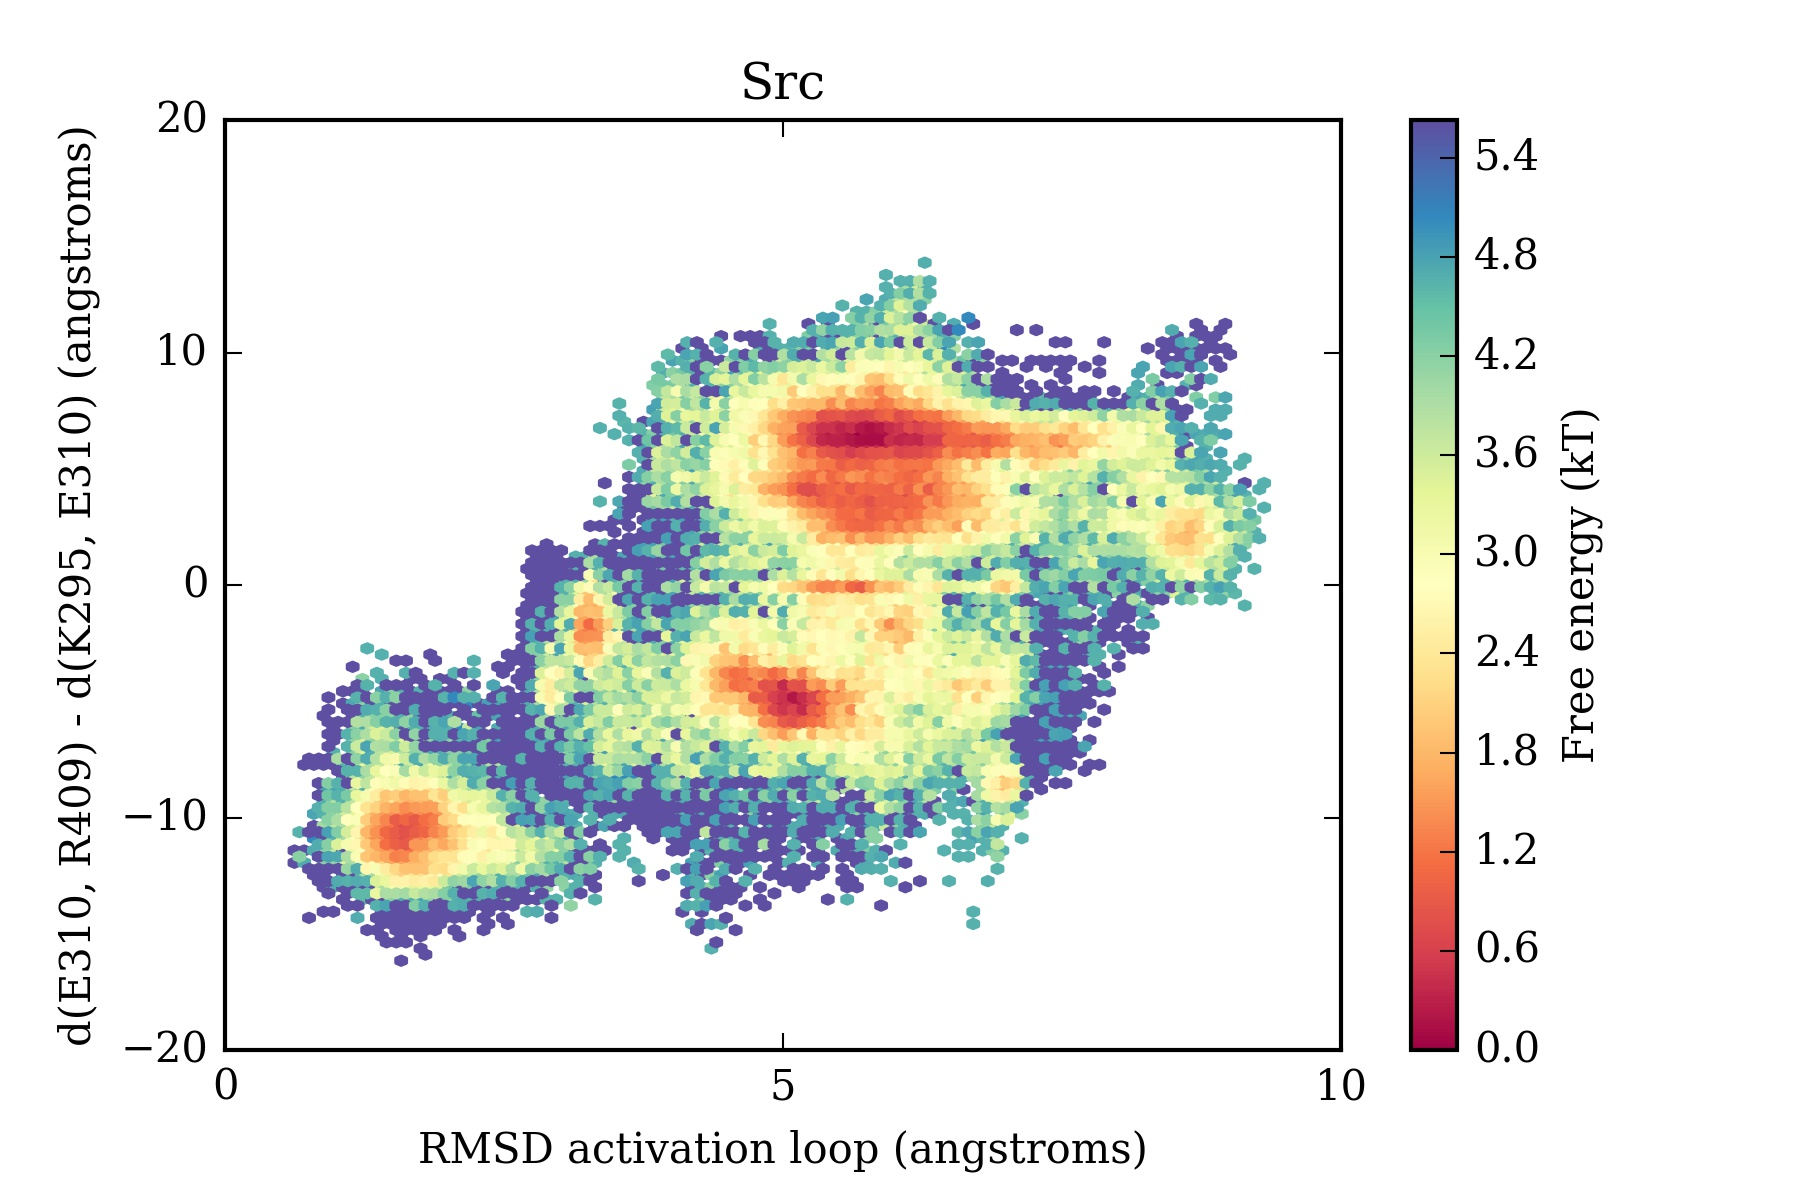

In [210]:
# now redo it for src!
bins=100

raw_dtrajs_src = load_dtrajs_from_npz('dtrajs/src_11401_2000_dtrajs.npz')
dtrajs_src = trim_dtrajs(raw_dtrajs_src)

mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Src',bins=bins)
plt.close()
shukla_plot_pe(X1,X2,flat_probs,'Src',bins=bins)
plt.close()

Image('Src_free_energy_landscape_hex.jpg',retina=True)

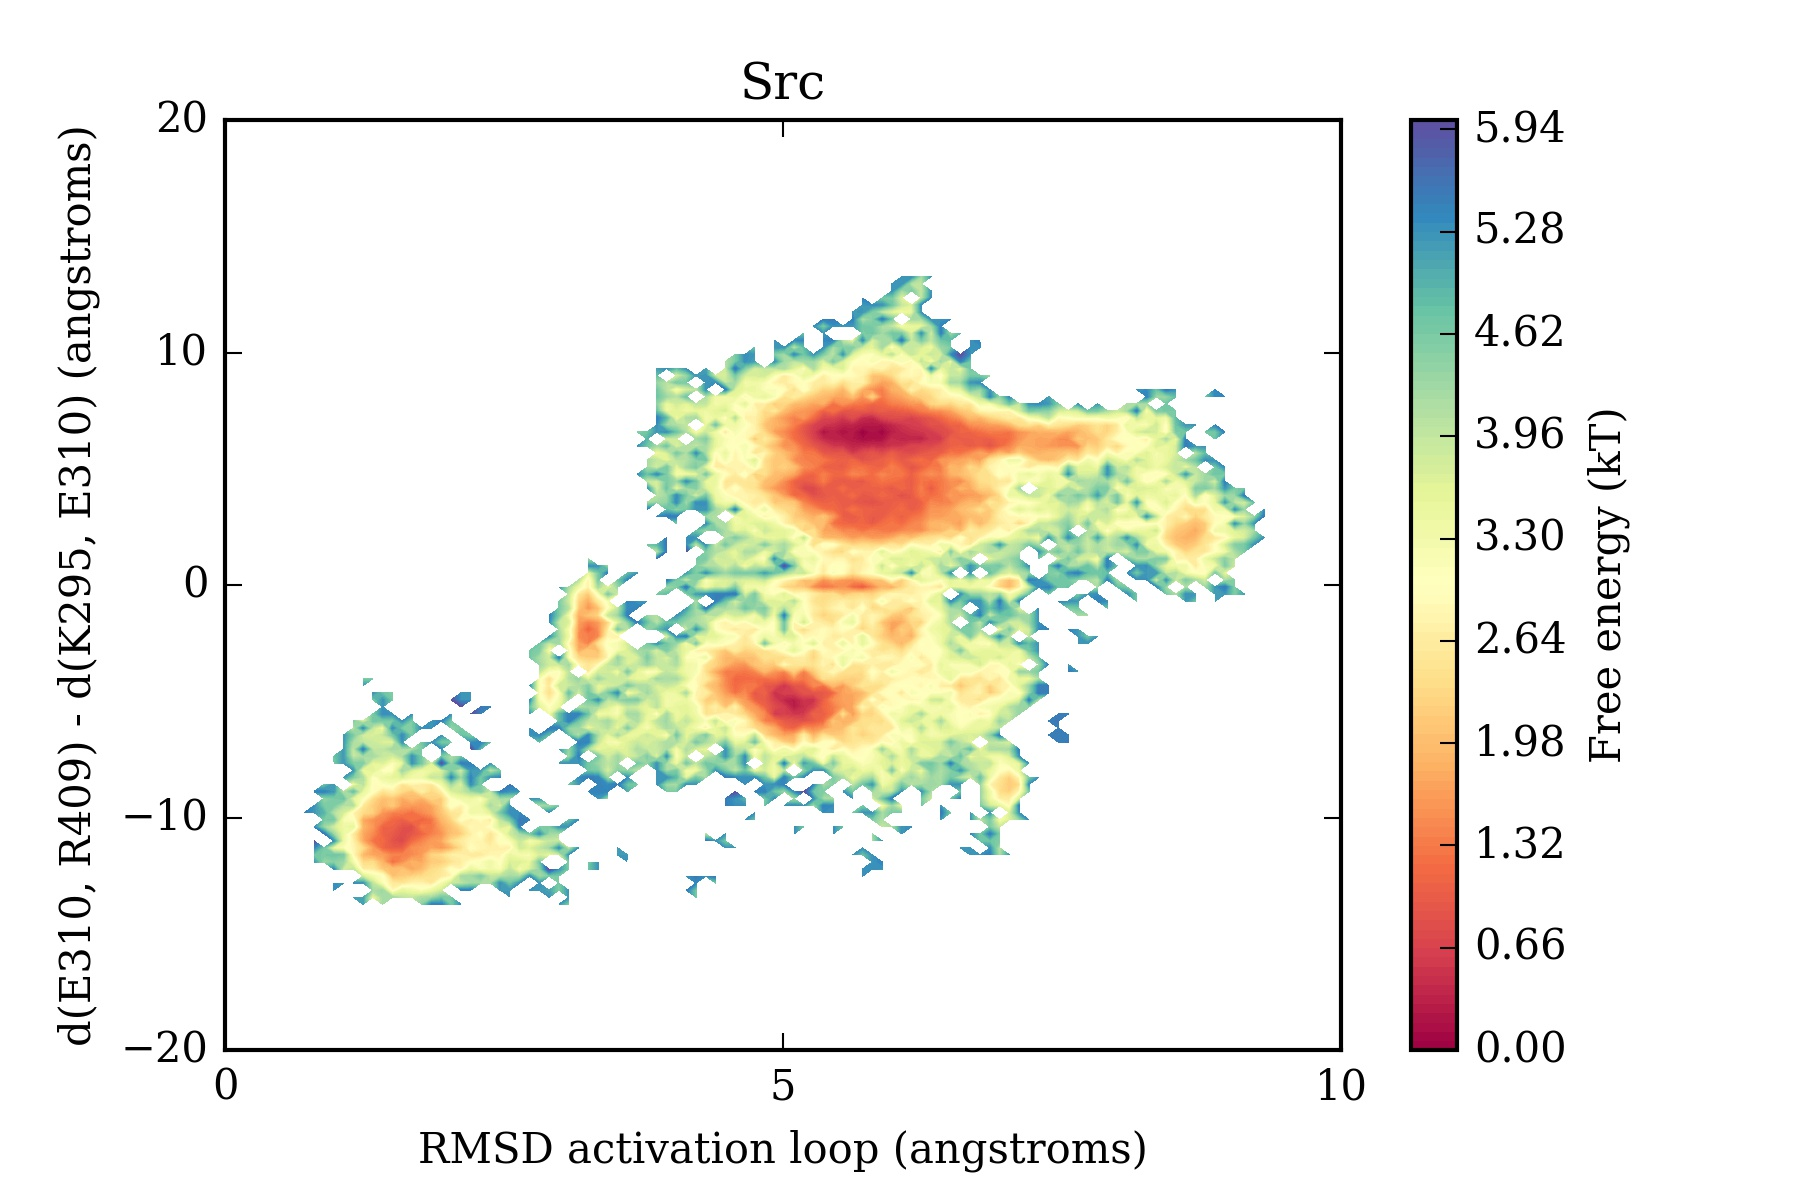

In [211]:
Image('Src_free_energy_landscape_pe.jpg',retina=True)

In [212]:
# now getting k-medoid representative locations
def get_flat_inds(model='abl'):
    if model=='abl':
        kmeds_f = 'abl_11400_2000_kmeds.pickle'
        dtrajs_f = 'dtrajs/abl_11400_2000_dtrajs.npz'
        dtrajs = raw_dtrajs_abl
    elif model=='src':
        kmeds_f = 'src_11401_2000_kmeds.pickle'
        dtrajs_f = 'dtrajs/src_11401_2000_dtrajs.npz'
        dtrajs = raw_dtrajs_src
    
    # load kmeds cluster model
    import cPickle
    f = open(kmeds_f,'r')
    kmeds = cPickle.load(f)
    f.close()

    # find mapping between trajectory id's in 
    from utils import find_one_step_mapping
    traj_mapping = find_one_step_mapping(dtrajs_f)
    inv_traj_map_dict = {v:k for k,v in traj_mapping.items()}
    def traj_frame_pair_to_flat_index(traj,frame,raw_dtrajs):
        ''' flat index = sum (lengths of all preceding trajs) + the frame
        number within current traj'''

        lens = [len(dtraj) for dtraj in raw_dtrajs]
        return sum(lens[:traj]) + frame

    # convert each cluster's traj,frame pair to a flat index
    flat_inds = []
    for traj,frame in kmeds.cluster_ids_:
        flat_inds.append(traj_frame_pair_to_flat_index(inv_traj_map_dict[traj],frame,dtrajs))
    flat_inds = np.array(flat_inds)
    return flat_inds

In [213]:
flat_inds_abl = get_flat_inds('abl')
flat_inds_src = get_flat_inds('src')

In [214]:
macrostate_ids_abl = np.load('macrostate_ids_abl.npy')

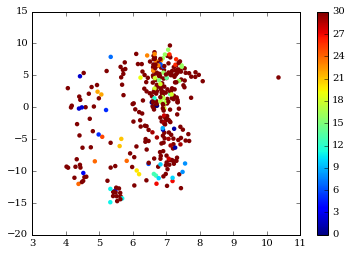

In [215]:
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

plt.scatter(X1[flat_inds_abl][macrostate_ids_abl!=-1],
            X2[flat_inds_abl][macrostate_ids_abl!=-1],
            c=macrostate_ids_abl[macrostate_ids_abl!=-1],
           linewidths=0)
plt.colorbar()

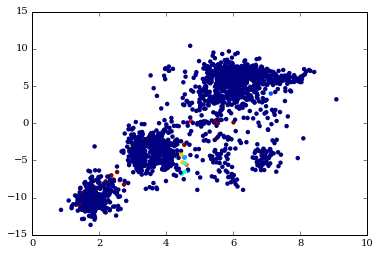

In [216]:
macrostate_ids_src = np.load('macrostate_ids_src.npy')

X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

plt.scatter(X1[flat_inds_src],X2[flat_inds_src],c=macrostate_ids_src,
           linewidths=0)

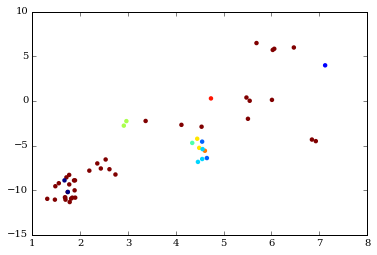

In [217]:
plt.scatter(X1[flat_inds_src][macrostate_ids_src!=-1],
            X2[flat_inds_src][macrostate_ids_src!=-1],
            c=macrostate_ids_src[macrostate_ids_src!=-1],
           linewidths=0)

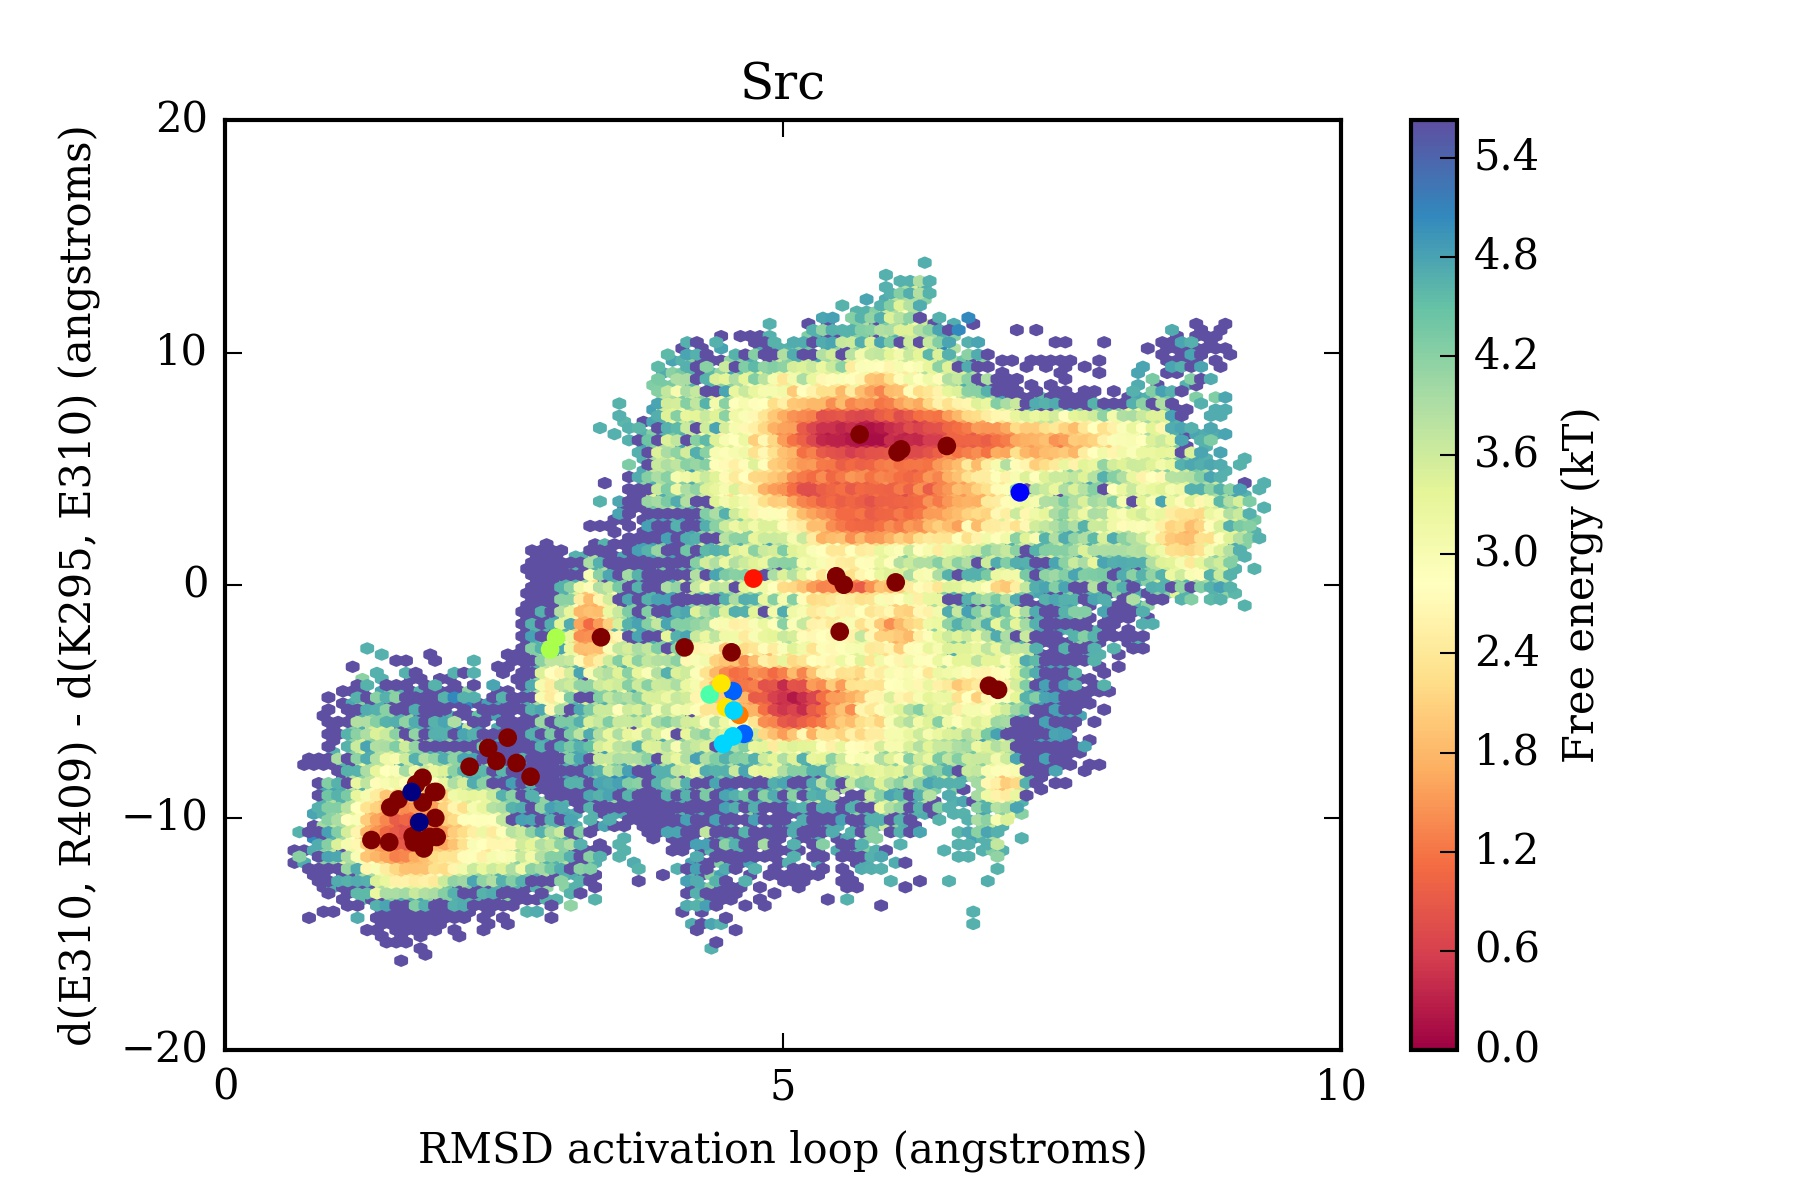

In [218]:
shukla_plot_hex(X1,X2,flat_probs,'Src',bins=bins)
plt.scatter(X1[flat_inds_src][macrostate_ids_src!=-1],
            X2[flat_inds_src][macrostate_ids_src!=-1],
            c=macrostate_ids_src[macrostate_ids_src!=-1],
           linewidths=0)
name = 'Src_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)

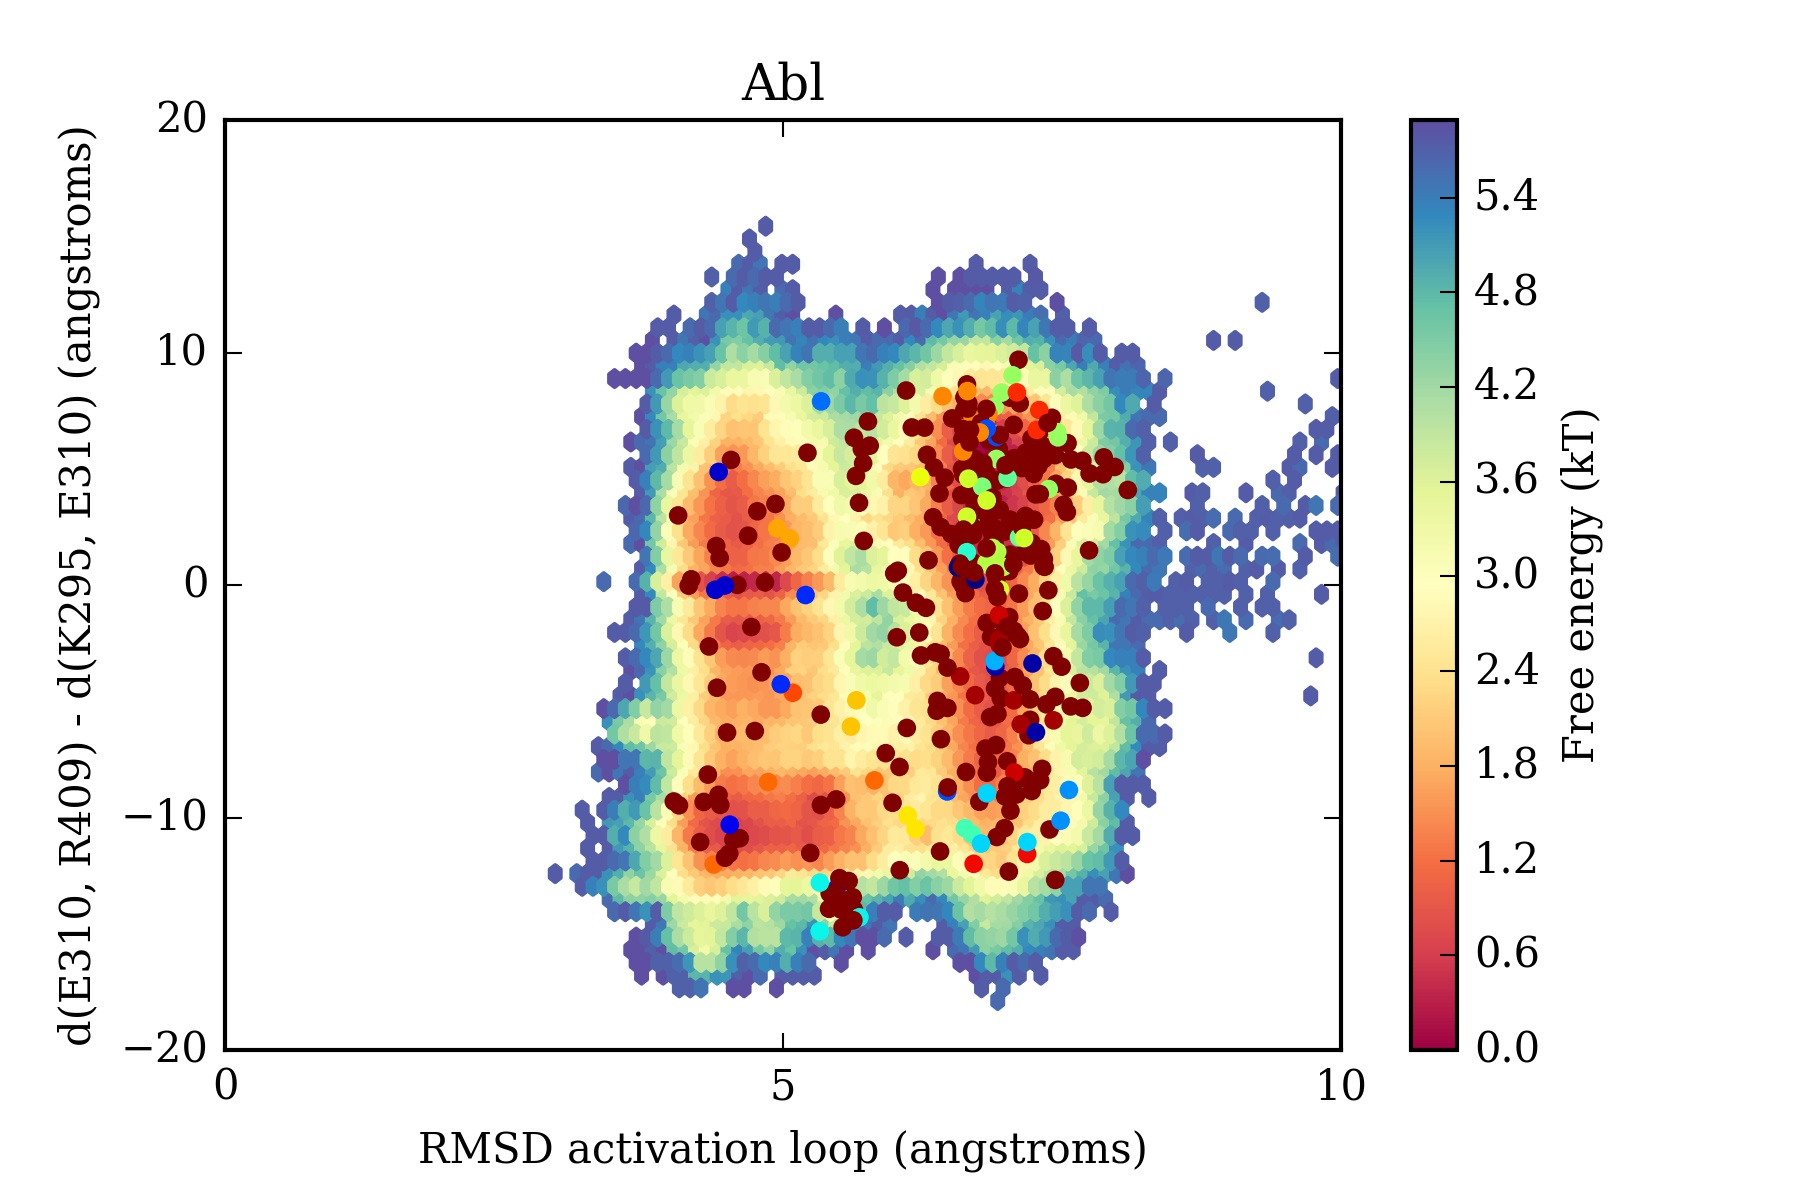

In [220]:
X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)

flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_abl,len(set(flat_labels)))

shukla_plot_hex(X1,X2,flat_probs,'Abl',bins=bins)

plt.scatter(X1[flat_inds_abl][macrostate_ids_abl!=-1],
            X2[flat_inds_abl][macrostate_ids_abl!=-1],
            c=macrostate_ids_abl[macrostate_ids_abl!=-1],
           linewidths=0)

name = 'Abl_free_energy_landscape_hex_plus_reps.jpg'
plt.savefig(name,dpi=300)
plt.close()
Image(name,retina=True)